In [6]:
# You don't need to run this--it's just a workaround so images show up in these Github Jupyter notebooks
from dapper.utils import display_image_gh_notebook
from IPython.display import HTML

## 4. Downloading global CMIP data
This notebook demonstrates how to download global CMIP6 files based on your criteria (variables, models, experiments, etc.). This notebook only walks through the process of downloading the raw CMIP6 files, not formatting them for ELM [funcationality does not yet exist].

`dapper` uses a Pangeo-hosted CMIP repository, as we found that ESGF was kinda tricky because of the transience and availability of nodes. The Pangeo archive standardizes everything into a quickly-searchable and downloadable archive, but it is not a perfect mirror of all the available data across ESGF. If you're not finding what you need here, you may have to look in ESGF. Note that Google Earth Engine also hosts a downscaled set of CMIP6 models/variables, but unfortunately it includes only a limited set of variables--not everything needed for ELM runs, so we do not provide functionality for sampling it.

Searching and downloading from the Pangeo archive does not require an account, so unlike ERA5-Land data that needs a Google Earth Engine account, this should work straight out of the box.

Similar to working with ERA5-Land Hourly data, here we will specify a `params` dictionary and then send our request. Let's look at these `params` a little bit here.

| Key          | Definition                                                                                                       | Examples                                                   |
|--------------|------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------|
| `models`     | Climate models (or "sources") that produced the simulation data, each with unique physics, resolution, and configurations. | `CESM2`, `IPSL-CM6A-LR`, `CanESM5`, `MPI-ESM1-2-HR`        |
| `variables`  | Climate variables simulated by the models, including atmospheric, oceanic, and land-surface data.                | `pr`, `tas`, `psl`, `ua`                                   |
| `experiment` | Predefined scenarios that specify forcing conditions used in climate simulations.                                | `historical`, `ssp245`, `ssp370`, `ssp585`, `piControl`    |
| `table`      | Frequency and domain of the model output data.                                                                   | `Amon`, `day`, `Omon`, `Lmon`                              |
| `ensemble`   | Identifier specifying realization, initialization, physics, and forcing configurations for the model run.        | `r1i1p1f1`, `r2i1p1f1`, `r1i2p1f2`                         |

You do not need to specify all of these. For example, if you're not sure which models you want, just leave it out and you'll be returned with all the models that match your other criteria. Let's try it out.

In [1]:
from dapper.cmip import cmip_utils as cuts
from dapper import utils

# We will leave models out for now
params = {
    'variables' : ['pr', 'tas'],
    'experiment' : 'historical',
    'table' : ['Amon'],
    'ensemble' : 'r1i1p1f1',
}

available = cuts.find_available_data(params)

print(available)


<pangeo-cmip6 catalog with 55 dataset(s) from 109 asset(s)>


We printed `available` but it's not immediately interpretable as it's an `intake-esm` class. We can use the `.df` attribute to get something that looks more familiar:

In [5]:
print(available.df)

    activity_id       institution_id          source_id experiment_id  \
0          CMIP            NOAA-GFDL           GFDL-CM4    historical   
1          CMIP            NOAA-GFDL           GFDL-CM4    historical   
2          CMIP                 IPSL       IPSL-CM6A-LR    historical   
3          CMIP                 IPSL       IPSL-CM6A-LR    historical   
4          CMIP            NASA-GISS        GISS-E2-1-G    historical   
..          ...                  ...                ...           ...   
104        CMIP                 IPSL  IPSL-CM6A-LR-INCA    historical   
105        CMIP                KIOST          KIOST-ESM    historical   
106        CMIP                KIOST          KIOST-ESM    historical   
107        CMIP  EC-Earth-Consortium      EC-Earth3-Veg    historical   
108        CMIP  EC-Earth-Consortium      EC-Earth3-Veg    historical   

    member_id table_id variable_id grid_label  \
0    r1i1p1f1     Amon          pr        gr1   
1    r1i1p1f1     Amon   

Now we see a table where each row corresponds to a dataset. Note that each variable will be on its own row, even if it comes from the same model, table, experiment, and ensemble. Let's say that you only want 10 samples of both `pr` and `tas` instead of the full catalog. We will do this by specifying the `Index` of `available.df` for the rows we want to keep. Here, we'll find 5 of these indexes. 

<div style="border: 2px solid #007ACC; background-color: #EAF4FF; padding: 10px; border-radius: 5px;">
<strong>💡 Note:</strong> You only need to do this step if you want to downselect from your returned query.
</div>


In [2]:
df = available.df.copy()

# Step 1: Find models that have both 'pr' and 'tas'
grouped = df.groupby('source_id')
keep = []
count = 0
for model, g in grouped:
    if 'tas' in g['variable_id'].values and 'pr' in g['variable_id'].values:
        keep.extend(g.index.tolist())
        count = count + 1
    if count > 4:
        break
df_export = df.iloc[keep]
print(df_export) # Now we have 10 models

   activity_id institution_id       source_id experiment_id member_id  \
54        CMIP   CSIRO-ARCCSS      ACCESS-CM2    historical  r1i1p1f1   
55        CMIP   CSIRO-ARCCSS      ACCESS-CM2    historical  r1i1p1f1   
59        CMIP          CSIRO   ACCESS-ESM1-5    historical  r1i1p1f1   
60        CMIP          CSIRO   ACCESS-ESM1-5    historical  r1i1p1f1   
79        CMIP            AWI   AWI-CM-1-1-MR    historical  r1i1p1f1   
88        CMIP            AWI   AWI-CM-1-1-MR    historical  r1i1p1f1   
72        CMIP            AWI  AWI-ESM-1-1-LR    historical  r1i1p1f1   
73        CMIP            AWI  AWI-ESM-1-1-LR    historical  r1i1p1f1   
6         CMIP            BCC     BCC-CSM2-MR    historical  r1i1p1f1   
7         CMIP            BCC     BCC-CSM2-MR    historical  r1i1p1f1   

   table_id variable_id grid_label  \
54     Amon         tas         gn   
55     Amon          pr         gn   
59     Amon          pr         gn   
60     Amon         tas         gn   
79    

Now that we have the set of models we want to download, let's download them! Note that these are on the order of 100-500 MB apiece so if you're just following this example, you may want to halt early or shrink `df_export` even further.

In [4]:
path_out = utils._DATA_DIR / 'cmip_downloads' / 'ex_global_files' # Set your path to where you want to store the files
cuts.download_pangeo(df_export, path_out)

Saved: tas_ACCESS-CM2_historical_r1i1p1f1.nc
Saved: pr_ACCESS-CM2_historical_r1i1p1f1.nc
Saved: pr_ACCESS-ESM1-5_historical_r1i1p1f1.nc
Saved: tas_ACCESS-ESM1-5_historical_r1i1p1f1.nc
Saved: pr_AWI-CM-1-1-MR_historical_r1i1p1f1.nc
Saved: tas_AWI-CM-1-1-MR_historical_r1i1p1f1.nc
Saved: tas_AWI-ESM-1-1-LR_historical_r1i1p1f1.nc
Saved: pr_AWI-ESM-1-1-LR_historical_r1i1p1f1.nc
Saved: tas_BCC-CSM2-MR_historical_r1i1p1f1.nc
Saved: pr_BCC-CSM2-MR_historical_r1i1p1f1.nc


And if we look in our specified directory, we should see all the files.


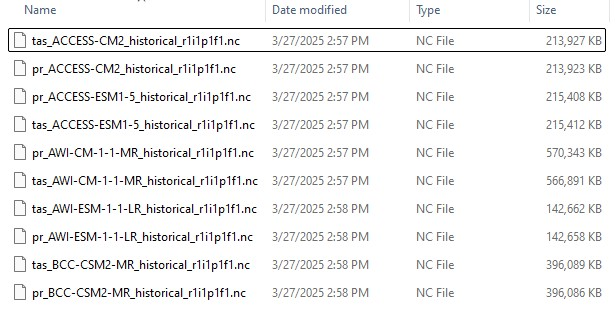

In [7]:
display(HTML(display_image_gh_notebook('4-files-proof.jpg')))